In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import library:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%tensorflow_version 2.1.0-rc0
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0-rc0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
train_df_ = pd.read_csv('/content/drive/Shared drives/2040Midterm/bangaliai-cv19/train.csv')
test_df_ = pd.read_csv('/content/drive/Shared drives/2040Midterm/bangaliai-cv19/test.csv')
class_map_df = pd.read_csv('/content/drive/Shared drives/2040Midterm//bangaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('/content/drive/Shared drives/2040Midterm//bangaliai-cv19/sample_submission.csv')


In [0]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [0]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [0]:
# load the 1st data file
train_df_1 = pd.read_parquet('/content/drive/Shared drives/2040Midterm/bangaliai-cv19/train_image_data_0.parquet')
train_df_1.head()

In [0]:
grapheme_root_img = train_df_.groupby(by=['grapheme_root']).count().reset_index()[['grapheme_root', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)
vowel_diacritic_img = train_df_.groupby(by=['vowel_diacritic']).count().reset_index()[['vowel_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)
consonant_diacritic_img = train_df_.groupby(by=['consonant_diacritic']).count().reset_index()[['consonant_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

In [0]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

# function to visualize the images
def visualize_image(df, image_id):
    '''
    Helper function to visualize the image from dataframe by image_id
    '''
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    plt.imshow(img.astype(float), cmap='gray')
    plt.show()

In [0]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet('/content/drive/Shared drives/2040Midterm/bangaliai-cv19/train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet('/content/drive/Shared drives/2040Midterm/bangaliai-cv19/test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test


In [0]:
# load the images
train, test = load_images()

In [0]:
from matplotlib.font_manager import FontProperties
prop = FontProperties()
prop.set_file('/content/drive/Shared drives/2040Midterm/Kalpurush.ttf')

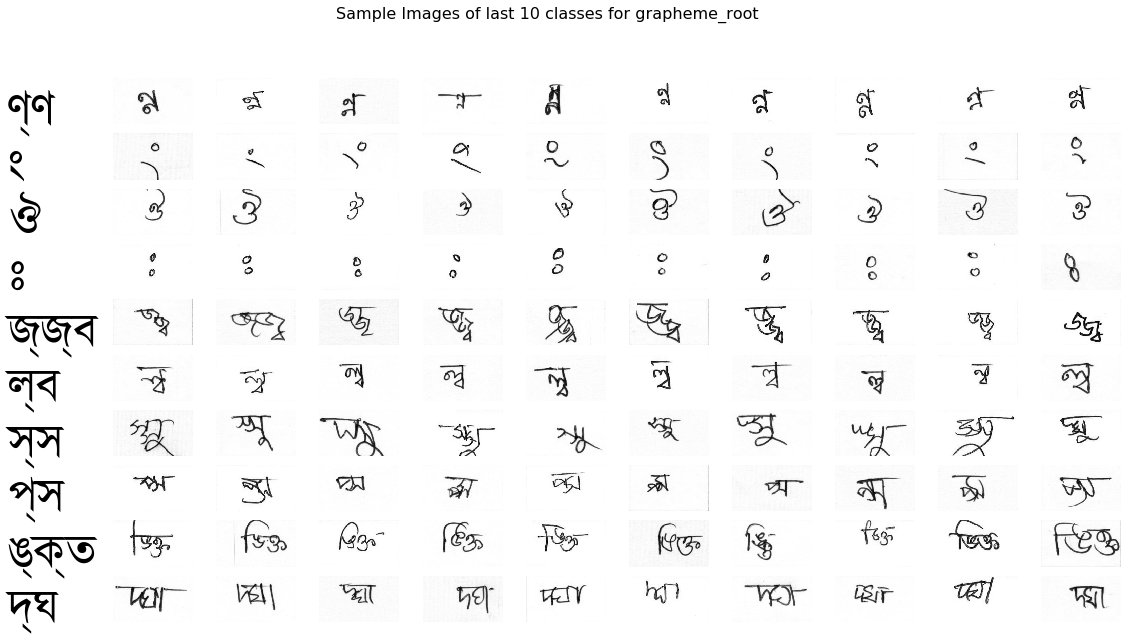

In [0]:
def class_to_component(label):
    '''
    Helper function to get the component by label
    '''
    return class_map_df[class_map_df.label == label].component.values[0]

def visualize_sample_graphemes(classes_list, label_type = 'grapheme_root', img_per_class=5):
    '''
    Helper function to plot the sample images for a list of class labels of specified type
    '''
    img_per_class = img_per_class+1
    fig, axs = plt.subplots(len(classes_list), img_per_class, figsize=(20,10))
    for row in range(len(classes_list)):
        # get sample ids for the class from the list
        all_img_ids = train_df_[train_df_[label_type] == classes_list[row]].image_id.values
        # get random indices
        np.random.seed(123)
        idx = np.random.randint(len(all_img_ids), size=img_per_class)
        for col in range(img_per_class):
            if col > 0:
                # get the id of the image
                img_id = all_img_ids[idx[col-1]]
                # get the image by id
                img = train[train.image_id == img_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
                axs[row, col].imshow(img, cmap='gray')
                axs[row, col].axis('off')
            else:
                # plot the component as text
                component = class_to_component(classes_list[row])
                axs[row, col].text(0, 0, component, fontproperties=prop, fontsize=48)
                axs[row, col].axis('off')
    plt.suptitle('Sample Images of last 10 classes for {}'.format(label_type), fontsize=16)
    plt.show()

# get top grapheme_root classes
n_classes = 10
top_grapheme_root = grapheme_root_img.grapheme_root.values[-n_classes:]
# visualize sample image
visualize_sample_graphemes(top_grapheme_root, label_type = 'grapheme_root', img_per_class=10)

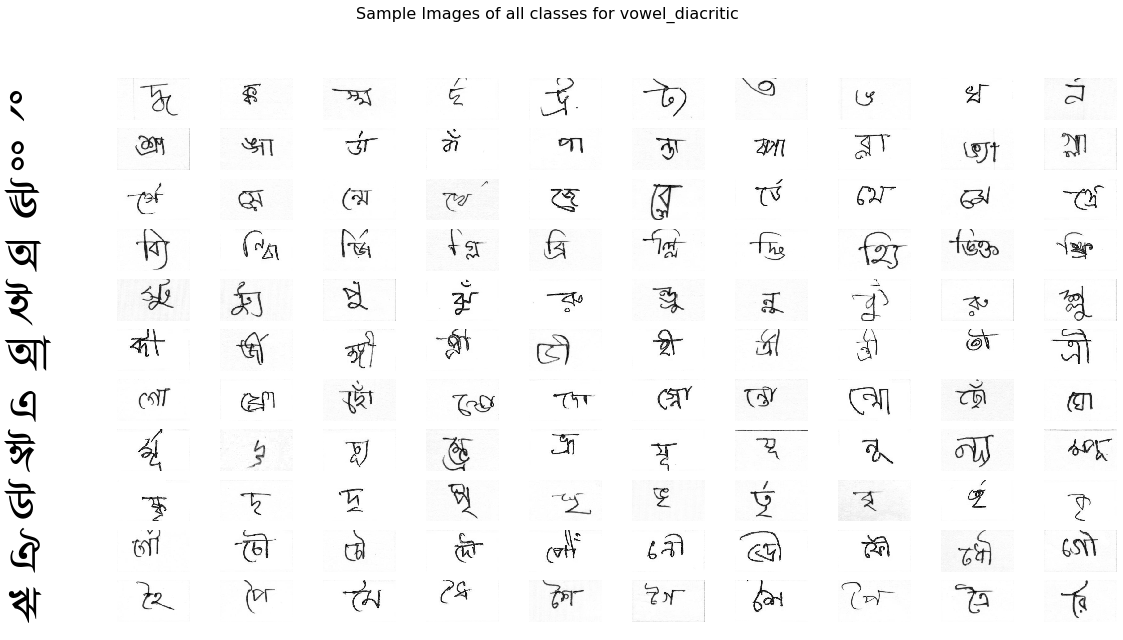

In [0]:
# visualize sample images for vowel_diacritic
visualize_sample_graphemes(vowel_diacritic_img.vowel_diacritic.values, label_type = 'vowel_diacritic', img_per_class=10)

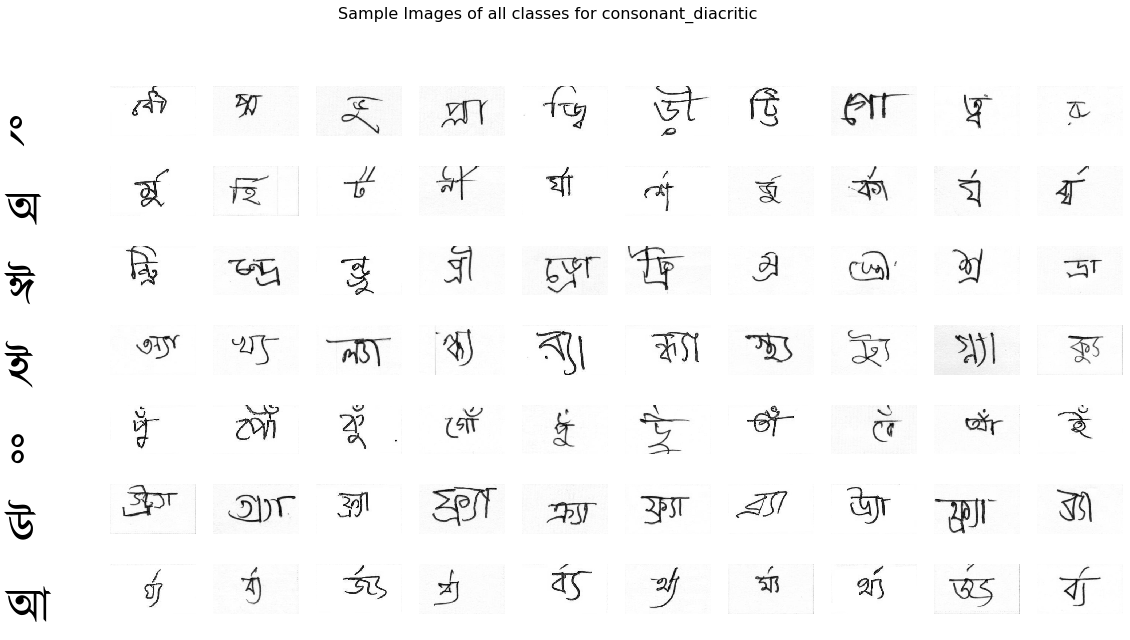

In [0]:
# visualize sample images for consonant_diacritic
visualize_sample_graphemes(consonant_diacritic_img.consonant_diacritic.values, label_type = 'consonant_diacritic', img_per_class=10)

In [0]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


In [0]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [0]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [0]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [0]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


Exploratory Data Analysis

In [0]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

Number of unique values

In [0]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


Most used top 10 Grapheme Roots in training set

In [0]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


Least used 10 Grapheme Roots in training set

In [0]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


Top 5 Vowel Diacritic in taining data¶

In [0]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


Top 5 Consonant Diacritic in training data

In [0]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


In [0]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [0]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [0]:
IMG_SIZE=64
N_CHANNELS=1

In [0]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [0]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

Basic Model

In [0]:
# from keras.layers import Conv2D

inputs = keras.Input(shape = (IMG_SIZE, IMG_SIZE, 1))

# inputs = keras.Sequential()
model = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.MaxPool2D(pool_size=(2, 2))(model)
model = keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.Dropout(rate=0.3)(model)

model = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.MaxPool2D(pool_size=(2, 2))(model)
model = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.Dropout(rate=0.3)(model)

model = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.MaxPool2D(pool_size=(2, 2))(model)
model = keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.Dropout(rate=0.3)(model)

model = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.MaxPool2D(pool_size=(2, 2))(model)
model = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = keras.layers.BatchNormalization(momentum=0.15)(model)
model = keras.layers.Dropout(rate=0.3)(model)

model = keras.layers.Flatten()(model)
model = keras.layers.Dense(1024, activation = "relu")(model)
model = keras.layers.Dropout(rate=0.3)(model)
dense = keras.layers.Dense(512, activation = "relu")(model)

head_root = keras.layers.Dense(168, activation = 'softmax')(dense)
head_vowel = keras.layers.Dense(11, activation = 'softmax')(dense)
head_consonant = keras.layers.Dense(7, activation = 'softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
batch_size = 256
epochs = 30

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [0]:
HEIGHT = 137
WIDTH = 236

In [0]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

Training loop:

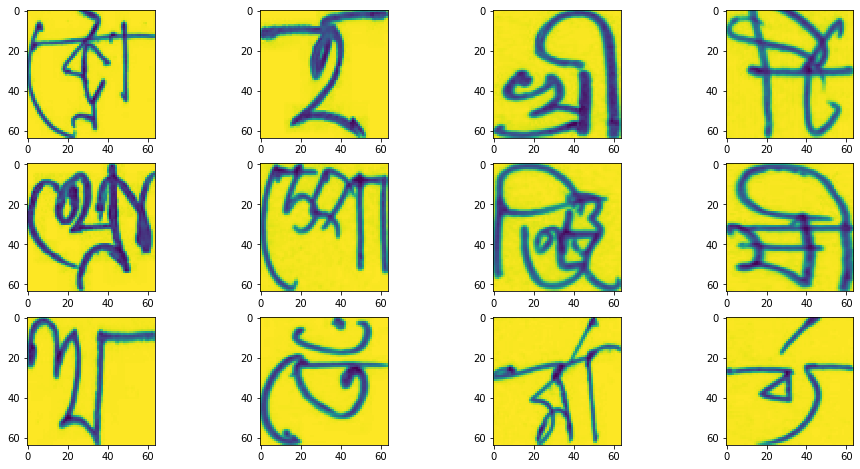


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Instructions for updating:
Please use Model.fit, which supports generators.
  {'dense_2': '...', 'dense_3': '...', 'dense_4': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 67s 373ms/step - loss: 7.9572 - dense_2_loss: 4.7530 - dense_3_loss: 1.9979 - dense_4_loss: 1.2063 - dense_2_accuracy: 0.0296 - dense_3_accuracy: 0.2793 - dense_4_accuracy: 0.6245 - val_loss: 6.9575 - val_dense_2_loss: 4.5872 - val_dense_3_loss: 1.3508 - val_dense_4_loss: 1.0204 - val_dense_2_accuracy: 0.0376 - val_dense_3_accuracy: 0.4976 - val_dense_4_accuracy: 0.6390
Epoch 2/30
180/180 [==============================] - 57s 319ms/step - loss: 6.7801 - dense_2_loss: 4.4999 - dense_3_loss: 1.3055 - dense_4_loss: 0.9747 - dense_2_accuracy: 0.0409 - dense_3_accuracy: 0.5406 - dense_

In [0]:
histories = []
for i in range(0,4):
    train_df = pd.merge(pd.read_parquet(
        f'/content/drive/Shared drives/2040Midterm/bangaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # tenserboard 
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    
    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_2': y_train_root, 'dense_3': y_train_vowel, 'dense_4': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[tensorboard_cb])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [0]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [0]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_2_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_2_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_2_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_2_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


In [0]:
histories[dataset].history['dense_2_accuracy']

In [0]:
for dataset in range(1):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')